In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
from warnings import filterwarnings
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
filterwarnings('ignore')

1. Our date here is csv file

In [24]:
df = pd.read_csv('./data/regresion_data.csv')
df = df.drop(columns='Unnamed: 0')
# there is no frq if there are no aerodnamic circuit => 
# => if label != 1.
# then
index_names = df[(df['label'] == 0)].index
df.drop(index_names, inplace = True)
# Also, after that segregation by the label, we can drop label column
df = df.drop(columns='label')
print(df.head(10))

   axial_max   tang_max  index_of_axm  index_of_tnm  axial_in_mxt   
0 -16.549675 -17.654378            28            48    -10.975493  \
1 -16.564726 -17.815883            28            52    -14.410172   
2 -16.335568 -17.578816            28            50    -12.664116   
3 -15.968865 -17.108087            28            47    -10.236513   
4 -15.227270 -16.266240            28            49    -12.056063   
5 -14.682051 -15.377140            27            51    -13.252567   
6 -14.086215 -14.515554            27            50    -12.391912   
7 -13.962619 -13.729980            28            45     -9.941273   
8 -13.620183 -13.183838            27            44     -9.637045   
9 -12.883969 -11.235115            24            41     -8.141471   

   tang_in_mxa  cone_angl   frequancy  
0   -16.597827          4  126.984123  
1   -16.724255          4  126.984123  
2   -16.415995          4  125.152626  
3   -15.878571          4  120.879120  
4   -15.246275          4  114.774117  


In [25]:
df.corr()

,axial_max,tang_max,index_of_axm,index_of_tnm,axial_in_mxt,tang_in_mxa,cone_angl,frequancy
axial_max,1.000000,0.900749,-0.729426,-0.752424,0.602443,0.899512,0.213329,-0.883728
tang_max,0.900749,1.000000,-0.804928,-0.780352,0.524339,0.979297,0.144075,-0.931279
index_of_axm,-0.729426,-0.804928,1.000000,0.613799,-0.345900,-0.759659,-0.084282,0.740377
index_of_tnm,-0.752424,-0.780352,0.613799,1.000000,-0.899130,-0.836412,-0.228411,0.751852
axial_in_mxt,0.602443,0.524339,-0.345900,-0.899130,1.000000,0.594057,0.247548,-0.480937
tang_in_mxa,0.899512,0.979297,-0.759659,-0.836412,0.594057,1.000000,0.175369,-0.944057
cone_angl,0.213329,0.144075,-0.084282,-0.228411,0.247548,0.175369,1.000000,-0.074179
frequancy,-0.883728,-0.931279,0.740377,0.751852,-0.480937,-0.944057,-0.074179,1.000000


<Axes: >

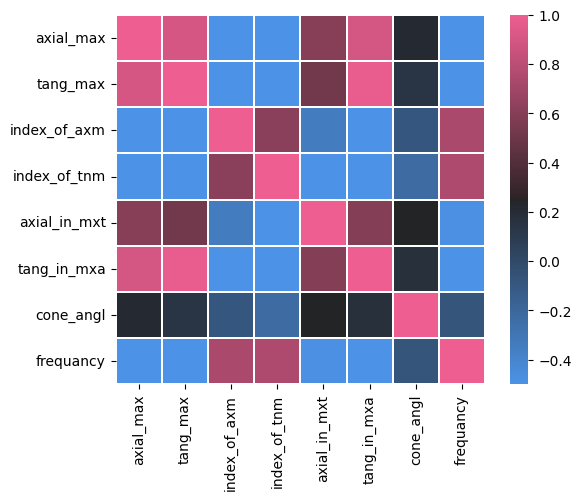

In [26]:
# check of independense

# Lets build something to visualise undepandance od data features
corr = df.iloc[:,:].corr(method='pearson')
cmap = sns.diverging_palette(250, 354, 80, 60, center = 'dark', as_cmap = True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

<Axes: >

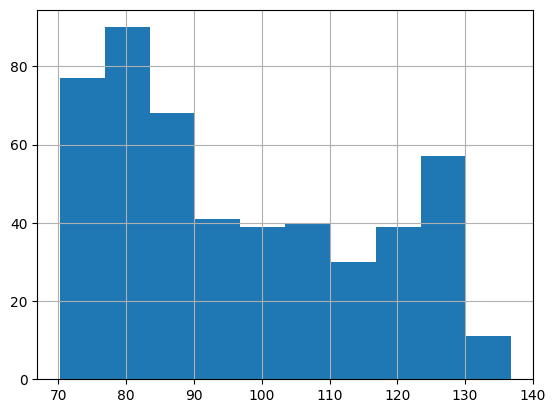

In [27]:
df['frequancy'].hist()

2. Let's try with not full data

In [28]:
df_first_modl = df[['tang_max', 'tang_in_mxa', 'frequancy']]

print(df_first_modl.shape)

(492, 3)


In [29]:
# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device


In [30]:
# Define a Dataset
def dataframe_to_arrays(input_cols, output_cols, dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

'''
inputs = torch.tensor(inputs_array, dtype=torch.float32)
targets = torch.tensor(targets_array, dtype=torch.float32)
'''

# Define a Dataset
class RegressionDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.from_numpy(X.astype('float32'))
        self.y = torch.from_numpy(y.astype('float32'))

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index].unsqueeze(0)

col = df_first_modl.columns
inputs_array, targets_array = dataframe_to_arrays(col[0:1], col[2], df_first_modl)
dataset = RegressionDataset(inputs_array, targets_array)

In [31]:
# Like thrain/test/split ?
train_dataset, test_dataset = random_split(dataset, lengths=[0.8, 0.2])

# Create DataLoaders ? For what ?
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=True
)

In [32]:
# Define Linear Regression Class
class LinearRegressionSimple(nn.Module):
    def __init__(self, in_features=1, out_features=1):
        super().__init__()
        self.linear = nn.Linear(
            in_features=in_features, 
            out_features=out_features
            )

    def forward(self, x):
        return self.linear(x)

# Another regresion model
# That's Multiple regression model
class MultipleRegression(nn.Module):
    
    def __init__(self, n_weight:int):
        super(MultipleRegression, self).__init__()
        """Initializing a Multiple regression model of the form:
        
    
        Args:
          n_weight (int): number of weigths
  
        """
        self.w = torch.randn(size =(n_weight,1), dtype=torch.double, 
                             requires_grad=True)
        self.b = torch.randn(1, requires_grad=True)

    def forward(self, X:torch.Tensor):
        """Forward pass for
        y = X * w.T + b

        Args:
          X (torch.Tensor): 2D tensor of observations x features

        Returns:
          torch.Tensor: model predictions
        """
        assert isinstance(X, torch.Tensor)
        prediction = X @ self.w + self.b
        return prediction

3. Train with linear regresion model, to see the base result

In [33]:
model = LinearRegressionSimple()

# Adding Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(params=model.parameters(), lr=0.001)

# Defining our device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setting up lists to track losses
train_losses = []
val_losses = []

# Defining a Training Function
def train(model, train_loader, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0

    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    avg_loss = train_loss/len(train_loader)
    print(f'Epoch [{epoch + 1:03}/{num_epochs:03}] | Train Loss: {avg_loss:.4f}')
    train_losses.append(train_loss/len(train_loader))

# Defining a Validation Function
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    avg_loss = val_loss / len(val_loader)
    print(f'Validation Loss: {avg_loss:.4f}')
    val_losses.append(avg_loss)

In [34]:
# Running our training loop
num_epochs = 30
model.to(device)
for epoch in range(num_epochs):
    train(model, train_loader, criterion, optimizer, epoch, num_epochs)
    validate(model, test_loader, criterion, device)

Epoch [001/030] | Train Loss: 3274.0359
Validation Loss: 156.7329
Epoch [002/030] | Train Loss: 96.6165
Validation Loss: 67.8485
Epoch [003/030] | Train Loss: 74.6688
Validation Loss: 71.9214
Epoch [004/030] | Train Loss: 79.0509
Validation Loss: 68.2148
Epoch [005/030] | Train Loss: 72.8680
Validation Loss: 73.6388
Epoch [006/030] | Train Loss: 75.8667
Validation Loss: 73.4369
Epoch [007/030] | Train Loss: 76.2749
Validation Loss: 72.3958
Epoch [008/030] | Train Loss: 82.1870
Validation Loss: 65.4751
Epoch [009/030] | Train Loss: 70.7648
Validation Loss: 65.5695
Epoch [010/030] | Train Loss: 73.4667
Validation Loss: 59.8702
Epoch [011/030] | Train Loss: 85.8247
Validation Loss: 73.4561
Epoch [012/030] | Train Loss: 81.0189
Validation Loss: 68.4328
Epoch [013/030] | Train Loss: 73.7715
Validation Loss: 67.8591
Epoch [014/030] | Train Loss: 75.3136
Validation Loss: 62.7719
Epoch [015/030] | Train Loss: 84.8933
Validation Loss: 75.4822
Epoch [016/030] | Train Loss: 70.3304
Validation Los

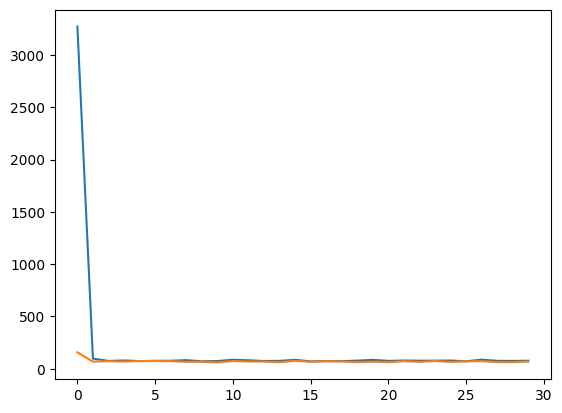

In [35]:
# Creating a Line Chart of Our Data
plt.plot(range(len(train_losses)), train_losses, val_losses)

4. Let's teach Multiple Regresion to compare results